Device: cuda
Classes: ['Blight', 'Healthy', 'Spot']


/tmp/ipython-input-3273149403.py:64: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(
/tmp/ipython-input-3273149403.py:151: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipython-input-3273149403.py:167: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[Epoch 1/50] Train Acc: 0.8989 | Val Acc: 0.9615
✅ Best model saved
[Epoch 2/50] Train Acc: 0.9857 | Val Acc: 0.9359
[Epoch 3/50] Train Acc: 0.9804 | Val Acc: 0.9744
✅ Best model saved
[Epoch 4/50] Train Acc: 0.9873 | Val Acc: 0.9615
[Epoch 5/50] Train Acc: 0.9884 | Val Acc: 0.9744
[Epoch 6/50] Train Acc: 0.9910 | Val Acc: 0.9359
[Epoch 7/50] Train Acc: 0.9952 | Val Acc: 0.9872
✅ Best model saved
[Epoch 8/50] Train Acc: 0.9926 | Val Acc: 0.9615
[Epoch 9/50] Train Acc: 0.9884 | Val Acc: 0.9744
[Epoch 10/50] Train Acc: 0.9968 | Val Acc: 0.9872
[Epoch 11/50] Train Acc: 0.9937 | Val Acc: 0.9231
[Epoch 12/50] Train Acc: 0.9889 | Val Acc: 0.9103
[Epoch 13/50] Train Acc: 0.9873 | Val Acc: 0.9744
[Epoch 14/50] Train Acc: 0.9958 | Val Acc: 0.9872
[Epoch 15/50] Train Acc: 0.9947 | Val Acc: 0.9872
[Epoch 16/50] Train Acc: 0.9958 | Val Acc: 0.9744
[Epoch 17/50] Train Acc: 0.9942 | Val Acc: 0.9487
[Epoch 18/50] Train Acc: 0.9979 | Val Acc: 0.9615
[Epoch 19/50] Train Acc: 0.9989 | Val Acc: 0.9615
[E

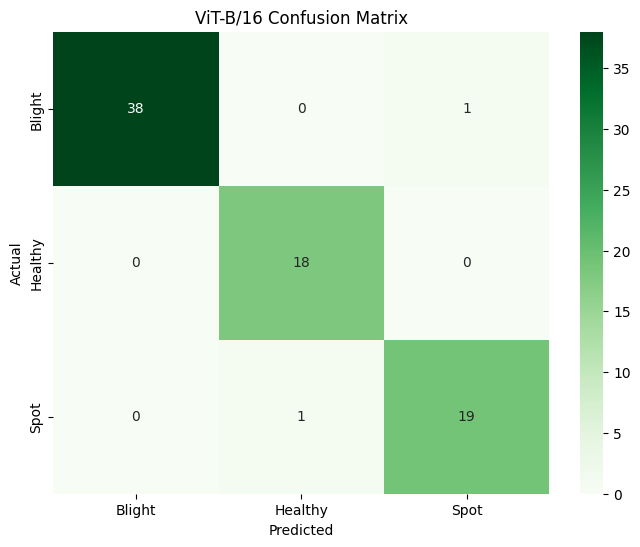

✅ Vision Transformer ماډل په Drive کې ذخیره شو


In [2]:
# ======================================================
# Vision Transformer (ViT-B/16) Training
# ImageNet Pretrained | Small Dataset (~2000 images)
# Batch=16 | No Gradient Accumulation
# ======================================================

# ----------------------
# Imports
# ----------------------
import os
import torch, timm
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix, f1_score, recall_score, precision_score

import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.cuda.amp import autocast, GradScaler

# ----------------------
# Device
# ----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ----------------------
# Paths
# ----------------------
DATA_DIR = "/content/drive/MyDrive/my Collected Dataset/Kandahar Field data/Actual Field_dataset With Original Background"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
VALID_DIR = os.path.join(DATA_DIR, "valid")
TEST_DIR  = os.path.join(DATA_DIR, "test")

# ----------------------
# Model Config
# ----------------------
MODEL_NAME = "vit_base_patch16_224"
IMG_SIZE = 224

# ----------------------
# Hyperparameters (Scientific Setup)
# ----------------------
BATCH = 16
NUM_EPOCHS = 50
LR = 3e-5                 # Low LR for ViT
WEIGHT_DECAY = 1e-4       # Important for ViT regularization

MODEL_SAVE = f"/content/best_{MODEL_NAME}_imagenet.pth"

# ----------------------
# Albumentations (Strong)
# ----------------------
train_tfms = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15, p=0.4),
    A.RandomBrightnessContrast(p=0.4),
    A.CoarseDropout(
        max_holes=2,
        max_height=32,
        max_width=32,
        p=0.3
    ),
    A.Normalize(mean=(0.485,0.456,0.406),
                std=(0.229,0.224,0.225)),
    ToTensorV2()
])

val_tfms = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=(0.485,0.456,0.406),
                std=(0.229,0.224,0.225)),
    ToTensorV2()
])

# ----------------------
# Dataset Wrapper
# ----------------------
class AlbDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform=None):
        self.dataset = datasets.ImageFolder(root)
        self.transform = transform
        self.classes = self.dataset.classes

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        path, label = self.dataset.samples[idx]
        img = np.array(Image.open(path).convert("RGB"))
        if self.transform:
            img = self.transform(image=img)["image"]
        return img, label

# ----------------------
# DataLoaders
# ----------------------
train_loader = DataLoader(
    AlbDataset(TRAIN_DIR, train_tfms),
    batch_size=BATCH,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    AlbDataset(VALID_DIR, val_tfms),
    batch_size=BATCH,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    AlbDataset(TEST_DIR, val_tfms),
    batch_size=BATCH,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

num_classes = len(train_loader.dataset.classes)
print("Classes:", train_loader.dataset.classes)

# ----------------------
# Model (Vision Transformer)
# ----------------------
model = timm.create_model(
    MODEL_NAME,
    pretrained=True,
    num_classes=num_classes,
    drop_rate=0.2        # extra regularization
).to(device)

# ----------------------
# Loss & Optimizer
# ----------------------
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=LR,
    weight_decay=WEIGHT_DECAY
)

scaler = GradScaler()

# ----------------------
# Training Loop
# ----------------------
best_val_acc = 0.0
train_acc_hist, val_acc_hist = [], []

for epoch in range(NUM_EPOCHS):
    model.train()
    correct, total = 0, 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()

        with autocast():
            outputs = model(imgs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    train_acc_hist.append(train_acc)

    # Validation
    model.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            preds = model(imgs).argmax(1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total
    val_acc_hist.append(val_acc)

    print(f"[Epoch {epoch+1}/{NUM_EPOCHS}] "
          f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), MODEL_SAVE)
        print("✅ Best model saved")

# ----------------------
# Testing
# ----------------------
model.load_state_dict(torch.load(MODEL_SAVE))
model.eval()

all_labels, all_preds = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        preds = model(imgs).argmax(1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

print("\nClassification Report:")
print(classification_report(all_labels, all_preds,
                            target_names=train_loader.dataset.classes))

print("F1:", f1_score(all_labels, all_preds, average="macro"))
print("Recall:", recall_score(all_labels, all_preds, average="macro"))
print("Precision:", precision_score(all_labels, all_preds, average="macro"))

# ----------------------
# Confusion Matrix
# ----------------------
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens",
            xticklabels=train_loader.dataset.classes,
            yticklabels=train_loader.dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("ViT-B/16 Confusion Matrix")
plt.show()

# ----------------------
# Save to Google Drive
# ----------------------
save_folder = "/content/drive/MyDrive/Corn_ViT_models"
os.makedirs(save_folder, exist_ok=True)

torch.save(model, f"{save_folder}/{MODEL_NAME}_full_model.pth")
torch.save(model.state_dict(), f"{save_folder}/{MODEL_NAME}_weights_only.pth")

print("✅ Vision Transformer ماډل په Drive کې ذخیره شو")


In [5]:
# creating the folder in drive with name of : models
!mkdir -p /content/drive/MyDrive/Corn_ViT_models

# copying the model file to the drive folder with the mentioned name: models
!cp /content/full_model.pth /content/drive/MyDrive/Corn_ViT_models/


save_folder = "/content/drive/MyDrive/Corn_ViT_models"
os.makedirs(save_folder, exist_ok=True)

torch.save(model, f"{save_folder}/{MODEL_NAME}_full_model.pth")
torch.save(model.state_dict(), f"{save_folder}/{MODEL_NAME}_weights_only.pth")

cp: cannot stat '/content/full_model.pth': No such file or directory
